In [24]:
%matplotlib inline

In [25]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import re
import pickle
import tensorflow as tf
import numpy as np 

In [26]:
def taylor_nn(prev_layer, weights, biases, com_type1, com_type2, act_type, num_of_layers, expansion_order, name ='U'):
    """Apply a NN to input from previous later

    Arguments:
        prev_layer      -- input from previous NN
        weights         -- dictionary of weights
        biases          -- dictionary of biases (uniform(-1,1) distribution, normal(0,1) distrubution, none--zeros)
        act_type        -- dictionary of activation functions (sigmoid, relu, elu, or none): user option 
        num_of_layers   -- number of weight matrices or layers: user option 
        expansion_order -- dictionary of Taylor expansion order: user option 

    Returns:
        output of network for input from previous layer
    """
    
    for i in np.arange(num_of_layers):
        #Compressor One###
        if com_type1['com1%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'relu':
            prev_layer = tf.nn.relu(prev_layer)
        elif com_type1['com1%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################
        
        #Compressor Two###
        if com_type2['com2%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif com_type2['com2%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################

        #save raw input###
        input_raw = prev_layer
        raw_input_shape = input_raw.shape
        ###################################################################################################################################
        
        #The expaned input via Taylor expansion is denoted by input_epd###
        input_epd = input_raw
        ###################################################################################################################################
    
        io = int(raw_input_shape[0])
        Id = np.arange(io)
        ###################################################################################################################################
        
       
        #Nolinear mapping through Taylor expansion###
        for _ in range(expansion_order['E%s%d' % (name, i +  1)]):
            for j in range(raw_input_shape[0]):
                for q in range(raw_input_shape[1]):
                    x_temp = tf.multiply(input_raw[j,q], input_epd[Id[j]:(Id[raw_input_shape[0]-1]+1),q])
                    x_temp = tf.expand_dims(x_temp,1)
                    if q == 0:
                        tem_temp = x_temp
                    else:
                        tem_temp = tf.concat((tem_temp,x_temp),1)
                Id[j] = input_epd.shape[0] 
                input_epd = tf.concat((input_epd,tem_temp),0)
        ###################################################################################################################################
             
        prev_layer = tf.matmul(weights['W%s%d' % (name,i + 1)],input_epd) + biases['b%s%d' % (name,i + 1)] 
        
        if act_type['act%s%d' % (name,i + 1)] == 'sigmoid':
            prev_layer = tf.sigmoid(prev_layer)
        elif act_type['act%s%d' % (name,i + 1)] == 'relu':
            prev_layer = tf.nn.relu(prev_layer)
        elif act_type ['act%s%d' % (name,i + 1)] == 'elu':
            prev_layer = tf.nn.elu(prev_layer)
        elif act_type ['act%s%d' % (name,i + 1)] == 'none':
            prev_layer = prev_layer
        ###################################################################################################################################    
        
    return prev_layer           

In [27]:
##Model Parameters#########################################################################################################
params = {}
input_dim = 7; 

params['uncheckable_dist_weights'] = ['tn','tn','tn']
params['uncheckable_output_size'] = [input_dim,350,10,2]
params['uncheckable_epd'] = np.array([0,0,1])
params['uncheckable_act'] = ['elu','elu','none']
params['uncheckable_com_type1'] = ['none','none','none']
params['uncheckable_com_type2'] = ['none','none','none']
params['uncheckable_dist_biases'] = ['normal','normal','normal']
params['uncheckable_num_of_layers'] = len(np.array([0,0,0])) 

params['checkable_dist_weights'] = ['tn']
params['checkable_output_size'] = [2,2]
params['checkable_epd'] = np.array([3])
params['checkable_act'] = ['none']
params['checkable_com_type1'] = ['none']
params['checkable_com_type2'] = ['none']
params['checkable_dist_biases'] = ['none']
params['checkable_num_of_layers'] = len(np.array([0])) 
###########################################################################################################################

In [28]:
##Load Weights, bias, activation and expansion order#####################################################################################################
WC = dict()
WU = dict()
bC = dict()
bU = dict()
act_typeC = dict()
act_typeU = dict()
com_typeU1 = dict() 
com_typeU2 = dict()
com_typeC1 = dict() 
com_typeC2 = dict()
expansion_orderU = dict()
expansion_orderC = dict()

for j in range(params['uncheckable_num_of_layers']):
    WU['WU%d' % (j + 1)] = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU['bU%d' % (j + 1)] = np.transpose(np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)))    
    act_typeU['actU%d' % (j + 1)] = params['uncheckable_act'][j]
    expansion_orderU['EU%d' % (j + 1)] = params['uncheckable_epd'][j]
    com_typeU1['com1U%d' % (j + 1)] = params['uncheckable_com_type1'][j]
    com_typeU2['com2U%d' % (j + 1)] = params['uncheckable_com_type2'][j]

for i in range(params['checkable_num_of_layers']):
    WC['WC%d' % (i + 1)] = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WC%d.csv" % (i+1), delimiter=',', dtype=np.float64))
    bC['bC%d' % (i + 1)] = np.transpose(np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bC%d.csv" % (i+1), delimiter=',', dtype=np.float64)))
    act_typeC['actC%d' % (i + 1)] = params['checkable_act'][i]
    expansion_orderC['EC%d' % (i + 1)] = params['checkable_epd'][i]
    com_typeC1['com1C%d' % (i + 1)] = params['checkable_com_type1'][i]
    com_typeC2['com2C%d' % (i + 1)] = params['checkable_com_type2'][i]
    
############################################################################################################################


In [29]:
##load data############################################################################################################
Xtest = np.matrix(np.loadtxt("../post/testdata/Car_test_X6.csv",delimiter=',', dtype=np.float64));
Ytest = np.matrix(np.loadtxt("../post/testdata/Car_test_Y6.csv",delimiter=',', dtype=np.float64));
Ztest = np.matrix(np.loadtxt("../post/testdata/Car_test_Z6.csv",delimiter=',', dtype=np.float64));
#######################################################################################################################

In [31]:
##Data from trained model##############################################################################################
ti = 1           ##testing point
tLen = 1        ##testing length


for u in range(tLen):
    
    #X = np.transpose(Xtest[ti+u,:])
    
    #print(X)
    #print(X.shape)
    
    X = np.transpose(np.transpose([[4.51634e-06],[0.000966611],[-0.325921],[-1.61015],[0.0278182],[0.0322638],[-0.00309674]]))
    
    #X = np.transpose(np.transpose([[3.50199e-05],[-0.0122974],[-0.3244],[-1.58798],[0.021715],[0.0255763],[0.00298251]]))
    
    
    #print(Y.shape)
    
    yrun = taylor_nn(prev_layer=X, weights=WU, biases=bU, com_type1=com_typeU1, com_type2=com_typeU2, act_type=act_typeU, 
                 num_of_layers=params['uncheckable_num_of_layers'], expansion_order=expansion_orderU,name='U')
    
    zrun = taylor_nn(prev_layer=yrun, weights=WC, biases=bC, com_type1=com_typeC1, com_type2=com_typeC2, act_type=act_typeC, 
                 num_of_layers=params['checkable_num_of_layers'], expansion_order=expansion_orderC,name='C')
    
    yrecord = yrun.eval(session=tf.compat.v1.Session())
    zrecord = zrun.eval(session=tf.compat.v1.Session())
    
    if u == 0:
        Y_train = yrecord
        Z_train = zrecord 
    else:
        Y_train = np.concatenate((Y_train,yrecord),axis= 1)
        Z_train = np.concatenate((Z_train,zrecord),axis= 1)
  ######################################################################################################################  

In [32]:
print(Y_train)

[[0.16383963]
 [0.1352844 ]]


In [33]:
print(Z_train)

[[ 0.00035058]
 [-0.02485622]]


In [25]:
##trure data###########################################################################################################
Ycom = np.transpose(Ytest[(ti):(ti+tLen),:])
Zcom = np.transpose(Ztest[(ti):(ti+tLen),:])
#######################################################################################################################

In [26]:
##process data##########################################################################################################
t = np.arange(tLen)
t = np.reshape(t,(1,tLen))

Y1_train = np.reshape(Y_train[0,:],(1,tLen))
Y1_com = Ycom[0,:].flatten()
Y2_train = np.reshape(Y_train[1,:],(1,tLen))
Y2_com = Ycom[1,:].flatten()
Z1_train = np.reshape(Z_train[0,:],(1,tLen))
Z1_com = Zcom[0,:].flatten()
Z2_train = np.reshape(Z_train[1,:],(1,tLen))
Z2_com = Zcom[1,:].flatten()

t = t.flatten()
Y1_train = (np.asarray(Y1_train)).flatten()
Y1_com = (np.asarray(Y1_com)).flatten()
Y2_train = (np.asarray(Y2_train)).flatten()
Y2_com = (np.asarray(Y2_com)).flatten()
Z1_train = (np.asarray(Z1_train)).flatten()
Z1_com = (np.asarray(Z1_com)).flatten()
Z2_train = (np.asarray(Z2_train)).flatten()
Z2_com = (np.asarray(Z2_com)).flatten()
########################################################################################################################################### 

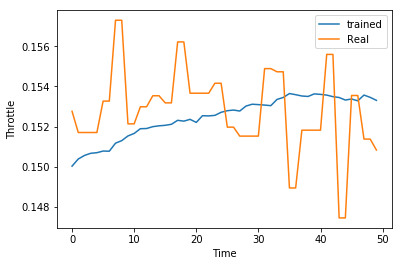

In [27]:
plt.plot(t,Y1_train,t,Y1_com)
plt.xlabel("Time")
plt.ylabel("Throttle")
plt.gca().legend(('trained','Real'))
plt.show()

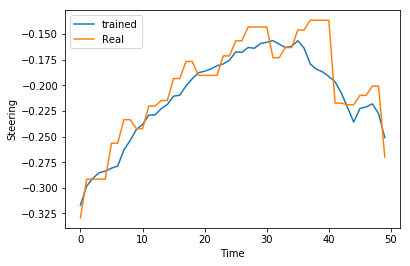

In [28]:
plt.plot(t,Y2_train,t,Y2_com)
plt.xlabel("Time")
plt.ylabel("Steering")
plt.gca().legend(('trained','Real'))
plt.show()

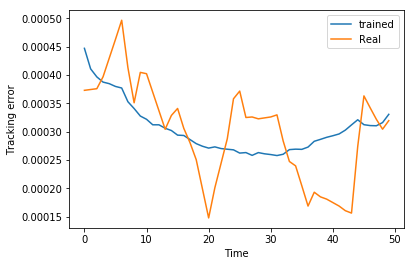

In [29]:
plt.plot(t,Z1_train,t,Z1_com)
plt.xlabel("Time")
plt.ylabel("Tracking error")
plt.gca().legend(('trained','Real'))
plt.show()

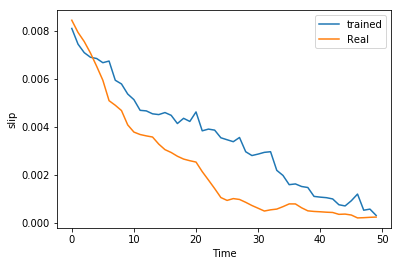

In [30]:
plt.plot(t,Z2_train,t,Z2_com)
plt.xlabel("Time")
plt.ylabel("slip")
plt.gca().legend(('trained','Real'))
plt.show()

In [31]:
test_error =  (np.mean(np.square(Y1_train - Y1_com)) + np.mean(np.square(Y2_train - Y2_com)) + np.mean(np.square(Z1_train - Z1_com)) + np.mean(np.square(Z2_train - Z2_com)))/6
    
print(test_error)  

6.525978303607751e-05


In [19]:
for j in range(params['uncheckable_num_of_layers']):
    WU = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 

    outfilewu = 'WU%d.npz' % (j + 1)
    outfilebu = 'bU%d.npz' % (j + 1)

    dctwu = {'1': WU}
    dctbu = {'1': bU}

    np.savez(outfilewu, **dctwu)
    np.savez(outfilebu, **dctbu)

    
for j in range(params['checkable_num_of_layers']):
    WC = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WC%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bC = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bC%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    
    outfilewc = 'WC%d.npz' % (j + 1)
    outfilebc = 'bC%d.npz' % (j + 1)
    
    dctwc = {'1': WC}
    dctbc = {'1': bC}
    
    np.savez(outfilewc, **dctwc)
    np.savez(outfilebc, **dctbc)
    

In [6]:
for j in range(params['uncheckable_num_of_layers']):
    WU = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bU = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bU%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 

    outfilewu = 'WU%d.npz' % (j + 1)
    outfilebu = 'bU%d.npz' % (j + 1)

    dctwu = {'1': WU}
    dctbu = {'1': bU}

    np.savez(outfilewu, **dctwu)
    np.savez(outfilebu, **dctbu)

    
for j in range(params['checkable_num_of_layers']):
    WC = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_WC%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    bC = np.matrix(np.loadtxt("../taylor_car_taylor_dn/exp_1_bC%d.csv" % (j+1), delimiter=',', dtype=np.float64)) 
    
    outfilewc = 'WC%d.npz' % (j + 1)
    outfilebc = 'bC%d.npz' % (j + 1)
    
    dctwc = {'1': WC}
    dctbc = {'1': bC}
    
    np.savez(outfilewc, **dctwc)
    np.savez(outfilebc, **dctbc)
    
    
#print(j)
#npzfile = np.load("../post/WU2.npz")
#print('npzfile.files: {}'.format(npzfile.files))
#print('npzfile["1"]: {}'.format(npzfile["1"]))
    
    

    

In [32]:
#print(j)
npzfile = np.load('../post/WU2.npz', allow_pickle = True)
a = npzfile['1']
print(a.shape)

(10, 350)
